# Flatiron School for Data Science - Capstone Project
* Student name: John J. Cho
* Student pace: full time online
* Instructor name: Rafael Carrasco
* Blog post URL: 

## Exploring Effects of Spring 2020 - COVID-19 Shelter-In-Place (SIP) - on Nintendo Switch Resale Pricing on eBay

In [198]:
# Importing libraries, files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import datetime as dt

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('df.csv')
df_lite = pd.read_csv('df_lite.csv')

#### Due to the frequency of missing information/pages for older listings, we will drop everything before 2020-02-14.

In [222]:
df = pd.read_csv('df.csv')


In [223]:
df.Date = pd.to_datetime(df.Date)
df = df[df.Date > '2020-02-13']
df.set_index('Date').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14681 entries, 2020-05-13 20:56:00 to 2020-02-13 00:10:00
Data columns (total 9 columns):
Title        14681 non-null object
Price        14681 non-null float64
Shipping     14681 non-null float64
Condition    14681 non-null object
Link         14681 non-null object
Location     14681 non-null object
Seller       14681 non-null object
Feedback     14681 non-null float64
FBScore      14681 non-null float64
dtypes: float64(4), object(5)
memory usage: 1.1+ MB


# Exploratory Data Analysis (EDA)
### Let's take an initial peek at a plot of our closing prices over time.

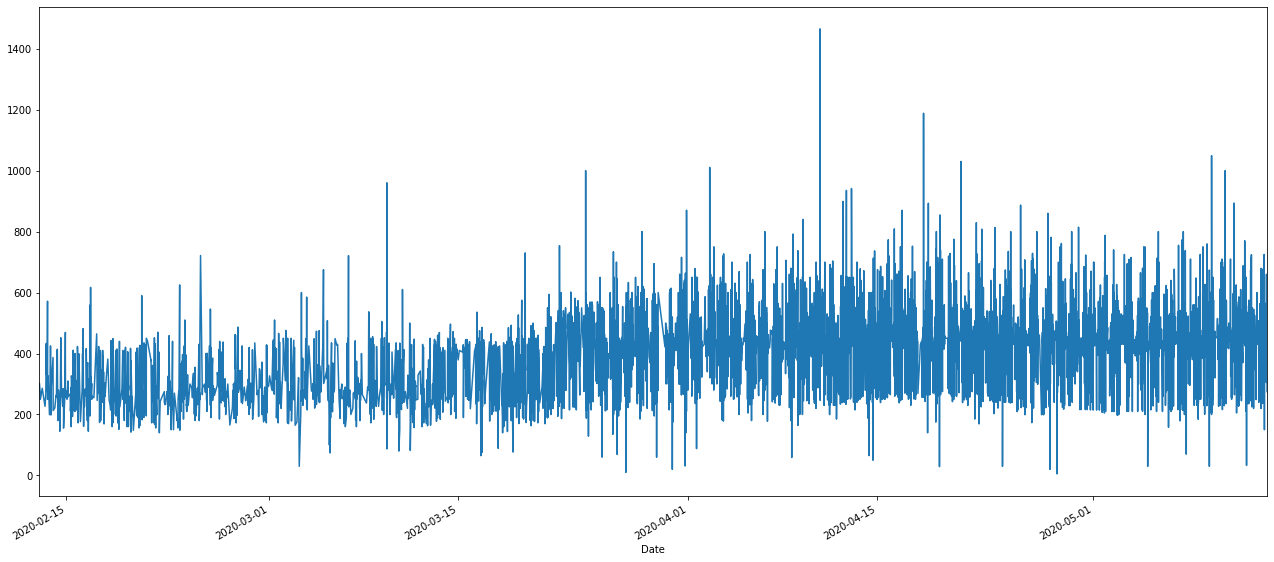

In [226]:
# First update Price to include Shipping so it correctly reflects total cost to buyer
#df.Price = df.Price + df.Shipping
df.set_index('Date').Price.plot(figsize=[22,10]);
#df[df.Date<'2020-02-28'].set_index('Date').Price.plot(figsize=[22,10]);

### As we can see, average prices held steady at the Switch's retail price of $300 until shelter-in-place began.

Beginning in mid March, there is a visible ramping up in the number of listings as well as average price rising by ~$100-125. However, we also see plenty of noise - deviations from the mean in the form of add-ons or limited features/editions which add value.. vs defects, age and usage which would reduce it.
>**Identifying these differences and quantifying or capturing their effects into new feature columns is necessary to improve accuracy for prediction modeling.**

Let's first drop the 'Parts Only' listings.

In [225]:
# Save into separate dataframe for analysis
df_parts_only = df[df.Condition == 'Parts Only']
df = df.drop(df_parts_only.index)

### Let's find the optimal 'before/after SIP effect' cutoff date that separates the two groups appropriately where the average price difference is greatest.
We will iterate thru the days from March 16 - April 1.

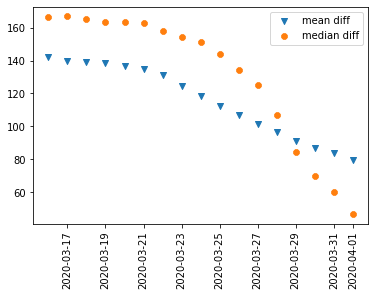

In [227]:
# Function to iterate 16 days from provided start date and plot average price differences between the groups
def find_cutoff(df,start):
    #Create new df to record average price differences between the 2 groups at given day threshold
    dft = pd.DataFrame(index=range(0,17),columns=['day','mean_diff','median_diff'])
    dft.day[0] = pd.to_datetime(start)
    from datetime import timedelta
    for x in range(1,17):  #fill in day values from provided start date
        dft.day[x] = dft.day[x-1] + timedelta(days=1)
    dft.day = pd.to_datetime(dft.day)

    # Optimal day threshold would be where the differences peak
    x = 0 #counter
    for day in dft.day:
        dft.mean_diff[x] = (df[df.Date >= day].Price.mean() - df[df.Date < day].Price.mean())
        dft.median_diff[x] = (df[df.Date >= day].Price.median() - df[df.Date < day].Price.median())
        x+=1
    #Plot differences for visual confirmation
    plt.scatter(dft.day,dft.mean_diff, marker='v', label='mean diff')
    plt.scatter(dft.day,dft.median_diff, marker='8', label='median diff')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show();
    
find_cutoff(df, '2020-03-16')

### That was unexpected! Let's try an earlier start date.

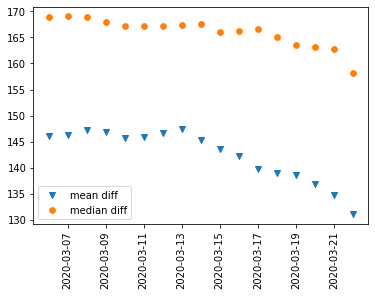

In [228]:
find_cutoff(df, '2020-03-06')

### How's that for a little creepy.. our optimal cutoff day (2020-03-13) was on Friday the 13th!
Apparently the market on eBay already started experiencing constrained supply and surging demand a few days before the earliest US shutdowns began.
>This makes sense, considering the already building panic evidenced by shortages of toilet paper, hand sanitizer and face masks - combined with the building anticipation of Animal Crossing's release on March 20.

## Homogenizing our dataset - separate listings into proper groups
- `Normal`: (average new[ish]) single system with a few add-ons such as games, accessories
- `Premium`: our high outliers, likely bundles with significant add-ons (games, accessories, limited/special editions)
- `Low`: (low outliers) - used, incomplete, damaged systems
- `Parts Only`: parted out or broken/heavy usage/older systems, accessories
- `Switch Lite`: (retail $199.99) already done earlier

In [218]:
df[df.Price<200][df.Date<'2020-03-13']

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore,City,State,Country
13811,2020-03-12 22:56:00,Nintendo Switch Lite Gray System in Box +Charger Saints Row The Third,165.00,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Lite-Gray-System-in-Box-Charger-Saints-Row-The-Third/12...,"['San Antonio', 'Texas', 'United States']",retroworldtx,150.0,94.9,San Antonio,Texas,United States
13826,2020-03-12 17:41:00,⭐️Nintendo Switch 32GB Gray Console Red and Blue JoyCon Does Not Read Games ⭐️⭐️,162.98,12.99,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-Console-Red-and-Blue-JoyCon-Does-Not-Read-Gam...,"['Dalton', 'Georgia', 'United States']",1upgamesllc,557.0,98.8,Dalton,Georgia,United States
13827,2020-03-12 17:40:00,Nintendo Switch w/ Neon Red and Blue Joy-Con - HAC-001 - 0245,199.99,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-w-Neon-Red-and-Blue-Joy-Con-HAC-001-0245/372975060680?h...,"['Onalaska', 'Wisconsin', 'United States']",epawnamerica,169664.0,99.9,Onalaska,Wisconsin,United States
13834,2020-03-12 15:15:00,Nintendo Switch 32GB Console Tablet Tested Working Minor Damage ver. 9.1.0 AS-IS,169.99,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-Tablet-Tested-Working-Minor-Damage-ver-9-1...,"['Lancaster', 'Pennsylvania', 'United States']",justpressplayonline,12704.0,100.0,Lancaster,Pennsylvania,United States
13839,2020-03-12 10:48:00,Nintendo Switch 32GB Console Tablet ONLY NO Accessories mint condition,172.55,16.10,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-Tablet-ONLY-NO-Accessories-mint-condition/...,"['Scarborough', 'Ontario', 'Canada']",surplusretro,19.0,100.0,Scarborough,Ontario,Canada
13844,2020-03-12 07:46:00,Nintendo Switch 32GB Console with Games/Accessories (Dock Not Included),160.00,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-with-Games-Accessories-Dock-Not-Included/1...,"['Greensburg', 'Pennsylvania', 'United States']",garrettpa,85.0,92.9,Greensburg,Pennsylvania,United States
13862,2020-03-11 17:45:00,Genuine Nintendo Switch 32GB Replacement Console Tablet Only,157.00,0.00,Pre-Owned,https://www.ebay.com/itm/Genuine-Nintendo-Switch-32GB-Replacement-Console-Tablet-Only-/153861399...,"['Euless', 'Texas', 'United States']",irvbudda_0,13.0,100.0,Euless,Texas,United States
13868,2020-03-11 15:13:00,Nintendo Switch 32GB Gray Console Tablet Only,173.85,23.85,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-Console-Tablet-Only-/313018473381?_trksid=p23...,"['Overland Park', 'Kansas', 'United States']",demor-7750,0.0,100.0,Overland Park,Kansas,United States
13870,2020-03-11 14:37:00,Nintendo HAC001 Gray Switch Game Console 7349,199.99,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-HAC001-Gray-Switch-Game-Console-7349/233513691277?hash=item365...,"['Anoka', 'Minnesota', 'United States']",epawnamerica,169482.0,99.9,Anoka,Minnesota,United States
13876,2020-03-11 10:55:00,Animal Crossing: New Horizons – Nintendo Switch + Journal Bundle TARGET PREORDER,82.19,11.19,Brand New,https://www.ebay.com/itm/Animal-Crossing-New-Horizons-Nintendo-Switch-Journal-Bundle-TARGET-PREO...,"['Blacksburg', 'Virginia', 'United States']",showcy-2012,171.0,95.8,Blacksburg,Virginia,United States


### View baseline figures: average profits before/after shelter-in-place

In [221]:
# Create estimated 'Profit' column which will subtract 300 retail price from Price+Shipping


In [228]:
df[df.Price<200]

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
611,2020-05-02 21:10:00,NINTENDO SWITCH LITE GRAY Brand NEW!! ~ SHIPS FREE SAME DAY,199.00,0.00,Brand New,https://www.ebay.com/itm/NINTENDO-SWITCH-LITE-GRAY-Brand-NEW-SHIPS-FREE-SAME-DAY/333585633511?ha...,"['Astoria', 'New York', 'United States']",quicksalesmp,1262.0,98.7
641,2020-05-02 18:52:00,Nintendo Switch Lite - Gray,197.50,0.00,Refurbished,https://www.ebay.com/itm/Nintendo-Switch-Lite-Gray/264713779873?hash=item3da22bbaa1:g:rgEAAOSwoS...,"['Cedar Park', 'Texas', 'United States']",ghernandez811,349.0,100.0
774,2020-05-02 09:11:00,NINTENDO SWITCH LITE Gray Handheld Video Game Console Grey (NEW) ready to ship,199.99,9.60,Brand New,https://www.ebay.com/itm/NINTENDO-SWITCH-LITE-Gray-Handheld-Video-Game-Console-Grey-NEW-ready-to...,"['Milwaukee', 'Wisconsin', 'United States']",kishalex,44.0,90.0
1847,2020-04-27 07:35:00,Nintendo Switch HAC-001(-01) 32GB Console with Gray Joy‑Con,190.00,9.20,Brand New,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Console-with-Gray-Joy-Con/402245900589?...,"['Monterey', 'California', 'United States']",redbull_6543,-1.0,100.0
1860,2020-04-27 04:18:00,Nintendo Switch HAC-001(-01) 32GB Console with Gray Joy‑Con,190.00,9.20,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Console-with-Gray-Joy-Con/164175856151?...,"['Monterey', 'California', 'United States']",jasa-9019,0.0,100.0
2039,2020-04-25 22:40:00,Nintendo Switch HAC-001(-01) 32GB Console with Gray Joyâ€‘Con,190.00,9.20,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Console-with-Gray-Joy-Con/383519841522?...,"['Monterey', 'California', 'United States']",jasa8096,0.0,100.0
2632,2020-04-22 13:18:00,Nintendo Switch 32GB Console without joycon comes with dock,156.00,13.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-without-joycon-comes-with-dock/37302963963...,"['Dawson Springs', 'Kentucky', 'United States']",ascar_1,0.0,100.0
3206,2020-04-19 08:33:00,Nintendo Switch HAC-001(-01) 32GB Tablet Only (Does not boot),175.00,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Tablet-Only-Does-not-boot/303542744515?...,"['Houston', 'Texas', 'United States']",ttntr0668_w22io53bv,39.0,100.0
4695,2020-04-12 00:05:00,Nintendo Switch Lite - Gray,180.00,5.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Lite-Gray/283843917065?hash=item42166a7509:g:j28AAOSwsW...,"['Middletown', 'Connecticut', 'United States']",jwilk61282012,24.0,100.0
4823,2020-04-11 11:48:00,"Nintendo Switch Case Is Broken ,Touch Screen Working ! For Parts,",189.99,9.60,New (Other),https://www.ebay.com/itm/Nintendo-Switch-Case-Is-Broken-Touch-Screen-Working-For-Parts/274333907...,"['Hollywood', 'Florida', 'United States']",carolinmontoy-0,238.0,100.0


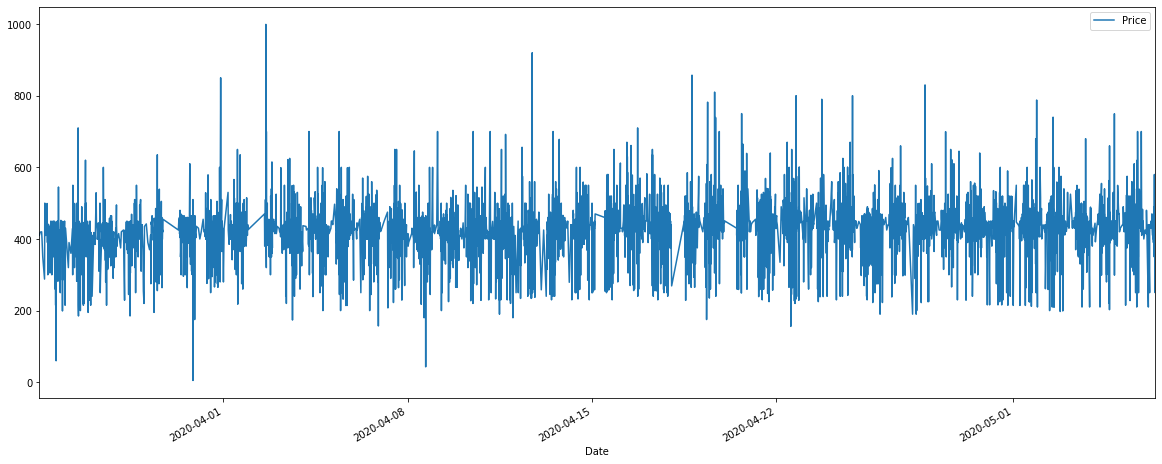

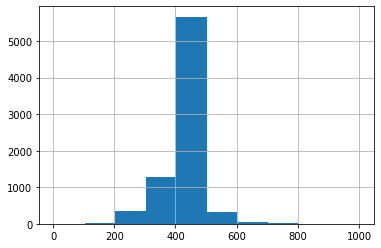

In [222]:
df[df.Date>'2020-03-25'].plot('Date','Price', figsize=[20,8]);
plt.show();
df[df.Date>'2020-03-25'].Price.hist();

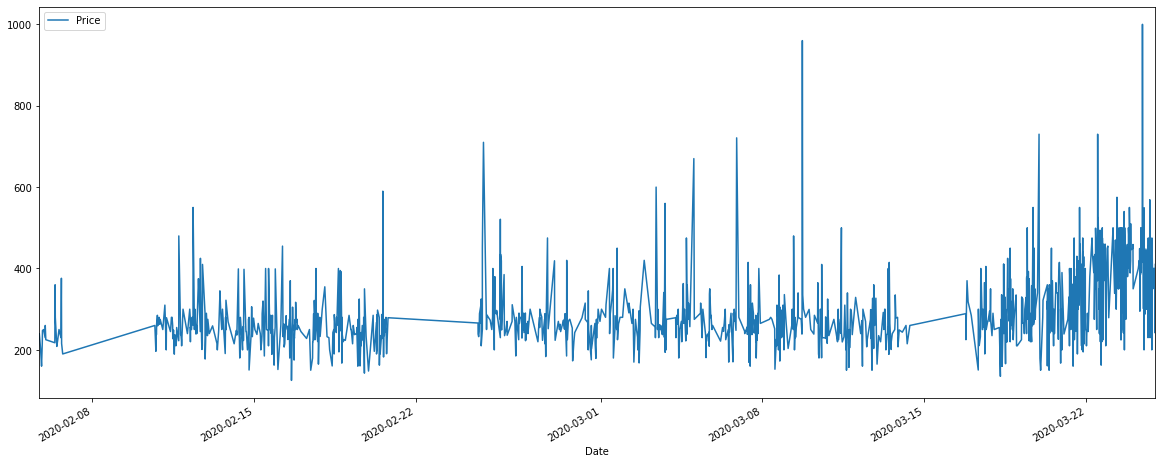

In [214]:
df[df.Date<='2020-03-25'].plot('Date','Price', figsize=[20,8]);

,Price,Shipping,Feedback,FBScore
Price,1.000000,-0.117080,-0.083055,0.011129
Shipping,-0.117080,1.000000,-0.016513,-0.001231
Feedback,-0.083055,-0.016513,1.000000,0.015556
FBScore,0.011129,-0.001231,0.015556,1.000000


### Question 1: How large (or small) is the pool of sellers?
    a. How diverse is the pool? Are some 'power sellers' dominating the market?  
    b. Did eBay benefit from a surge of new seller accounts after shelter-in-place began?  
    c. Are the 'power sellers' consistently selling for higher closing prices?

In [143]:
# Set power seller cutoff 
p_sellers = df.Seller.value_counts()[df.Seller.value_counts()>=3]
r_sellers = df.Seller.value_counts()[df.Seller.value_counts()<3]
print(df.shape, len(p_sellers), len(r_sellers))
p_sellers.head(10)

(12813, 12) 996 6358


 pickingout             92
 thimothyboy            66
 twobrothersgames       65
 wendell13172           53
 4shoresoles            45
 yoursavings            41
 rcherry2121            36
 andshe_9687            34
 d.zellers              30
 moviestarplanet2015    30
Name: Seller, dtype: int64

In [194]:
p_sellers.sum(), r_sellers.sum()

(3485, 5578)

### Question 2: How has the geography of sellers changed since SIP began?

In [ ]:
# Create new columns for each location field
df['City'] = df.Location.str[0]
df['State'] = df.Location.str[1]
df['Country'] = df.Location.str[2]

In [ ]:
# Fix location values incorrectly stored as string instead of list
notlist = []
i = 0
for x in df.Location:
    if not isinstance(x, list): notlist.append(i)
    i+=1

for i in notlist:
    df.Location.iloc[i] = [df.Location.iloc[i][1:-1].split(',')[0][1:-1],df.Location.iloc[i][1:-1].split(',')[1][2:-1],
                               df.Location.iloc[i][1:-1].split(',')[2][2:-1]]

In [127]:
cities = df.City.value_counts()
cities.head(10)

Chicago          193
New York         190
Brooklyn         173
Los Angeles      135
Portland         132
Houston          115
San Diego        104
Miami            103
Union            101
San Francisco     98
Name: City, dtype: int64

In [128]:
states = df.State.value_counts()
states.head(10)

California      1863
New York        1168
Florida          970
Texas            800
New Jersey       691
Illinois         648
Pennsylvania     560
Georgia          374
Virginia         337
Michigan         325
Name: State, dtype: int64

In [130]:
countries = df.Country.value_counts()
countries.head(10)

United States         12347
Canada                  421
Japan                     7
Russian Federation        5
Portugal                  5
Poland                    5
Czech Republic            4
Puerto Rico               3
Malaysia                  3
Brand New                 2
Name: Country, dtype: int64

In [142]:
overseas = ['United States','Canada']
df[df.Country.map(lambda x: False if x in overseas else True)]

,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore,City,State,Country
Date,,,,,,,,,,,,
2020-05-07 21:26:00,Animal Crossing Handheld Pouch Case for Switch & Switch Lite Console (HORI),39.99,29.99,Brand New,https://www.ebay.com/itm/Animal-Crossing-Handheld-Pouch-Case-for-Switch-Switch-Lite-Console-HORI...,"[Genuine, Original, Brand New]",gameofasia,10061.0,97.2,Genuine,Original,Brand New
2020-05-05 11:01:00,Nintendo Switch 32GB Gray Console with Neon Red and Neon Blue Joy-Con,403.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-Console-with-Neon-Red-and-Neon-Blue-Joy-Con-/...,"[Toluca, STATE, Mexico]",58_jzqf4,0.0,100.0,Toluca,STATE,Mexico
2020-05-04 18:05:00,ðŸ”¥ NEW - Nintendo Switch Animal Crossing New Horizons Console LAST IN STOCK!!!ðŸ”¥,700.00,50.00,Brand New,https://www.ebay.com/itm/NEW-Nintendo-Switch-Animal-Crossing-New-Horizons-Console-LAST-IN-STOCK/...,"[Lódz, STATE, Poland]",arkauc_45,1.0,100.0,Lódz,STATE,Poland
2020-05-04 02:54:00,Nintendo Switch 32GB Gray Console with Neon Red and Neon Blue Joy-Con,392.02,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-Console-with-Neon-Red-and-Neon-Blue-Joy-Con-/...,"[Mexico, STATE, Mexico]",ismael-narv,0.0,100.0,Mexico,STATE,Mexico
2020-05-02 13:30:00,"Nintendo Switch 32GB Console w/ Gray Joyâ€‘Con, Game and Acessories",355.00,20.00,Open Box,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-w-Gray-Joy-Con-Game-and-Acessories/1241738...,"[Azores, STATE, Portugal]",imrudas,43.0,100.0,Azores,STATE,Portugal
2020-05-02 10:07:00,"Nintendo Switch 32GB Console w/ Gray Joyâ€‘Con, Game and Acessories",340.00,15.00,Open Box,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-w-Gray-Joy-Con-Game-and-Acessories/1241736...,"[Azores, STATE, Portugal]",imrudas,43.0,100.0,Azores,STATE,Portugal
2020-04-30 09:49:00,"Nintendo Switch 2019, 32GB Console with Gray Joy‑Con. Updated battery",485.00,13.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-2019-32GB-Console-with-Gray-Joy-Con-Updated-battery/114...,"[Esbjerg, STATE, Denmark]",andreasrosenberg2013,86.0,100.0,Esbjerg,STATE,Denmark
2020-04-30 06:07:00,Nintendo Switch HAC-001(-01) 32GB Console with Gray Joy‑Con,400.00,9.97,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Console-with-Gray-Joy-Con/124170191921?...,"[Aguada PR, STATE, Puerto Rico]",bryan_blazquez,340.0,100.0,Aguada PR,STATE,Puerto Rico
2020-04-29 12:47:00,ðŸ”¥ NEW - Nintendo Switch Animal Crossing New Horizons Console LAST IN STOCK!!!ðŸ”¥,560.00,50.00,Brand New,https://www.ebay.com/itm/NEW-Nintendo-Switch-Animal-Crossing-New-Horizons-Console-LAST-IN-STOCK/...,"[Lódz, STATE, Poland]",arkauc_45,1.0,100.0,Lódz,STATE,Poland


### Question 3: Is it better to charge shipping to the buyer or to provide it for free?
a. As a seller - would 'eating' the shipping cost be worth the 'investment'?   
b. Would a greater crowding effect magnify the benefit of free shipping? Alternatively, does charging shipping lose its negative effect for the same reason?
(shipping info does not show whether it was set to carrier rates or fixed amount set by seller)

In [206]:
# View 5-point metrics, how many listings had free shipping
df.Shipping.describe(), df[df.Shipping==0].shape

(count    9063.000000
 mean       10.351345
 std        11.455909
 min         0.000000
 25%         0.000000
 50%         9.000000
 75%        20.800000
 max       121.450000
 Name: Shipping, dtype: float64, (4289, 10))

### Question 4: Does the condition of the Switch (brand new vs not) matter as much during this period?

### Question 5: Have many eBay seller accounts been created specifically to sell a pre-owned Switch?
a. What about new seller accounts specifically to resell Switches for profit?   
b. Does a zero rating (new) seller matter as much in this unique selling climate?

In [153]:
df.Condition.value_counts()

Brand New      5759
Pre-Owned      2433
Refurbished     392
Open Box        375
New (Other)     104
Name: Condition, dtype: int64

### Let's take a closer look at the `Condition`: 'Parts Only' listings which represent broken, dismantled or partial systems which would be considered outliers.

In [9]:
df_parts_only.head(3)

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
43,2020-05-06 05:13:00,Nintendo Switch UNPATCHED Console with color Joy‑Con NO POWER,239.99,0.0,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-UNPATCHED-Console-with-color-Joy-Con-NO-POWER/264722154...,"['Cape Coral', 'FL', 'United States']",electronicas2012,101.0,90.2
167,2020-05-05 12:00:00,Nintendo Switch HAC-001 32GB Console with Gray Joy‑Con - WATER DAMAGE,220.00,10.0,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-32GB-Console-with-Gray-Joy-Con-WATER-DAMAGE/254...,"['Los Angeles', 'California', 'United States']",zella05nic,245.0,100.0
238,2020-05-05 05:23:00,"Nintendo Switch Console HACSKABAA, - Locked",209.00,0.0,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Console-HACSKABAA-Locked-/264716338990?_trksid=p2349526...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3


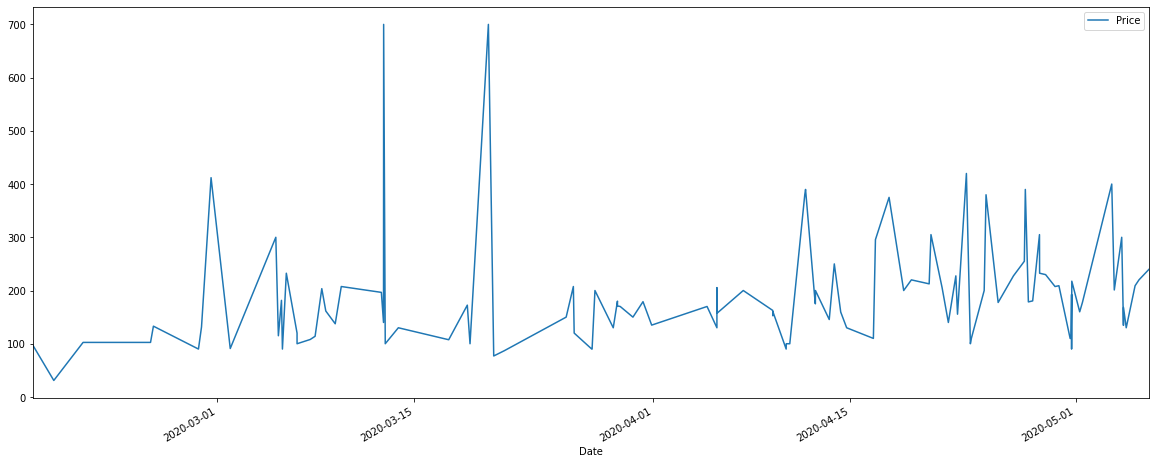

In [46]:
# Set Date as index before plotting
df_parts_only.Date = pd.to_datetime(df_parts_only.Date)
df_parts_only.set_index('Date', inplace=True)
df_parts_only.plot(y='Price', figsize=[20,8])

In [97]:
df_parts_only.reset_index(inplace=True)
df_parts_only[df_parts_only.Price>=200]  #

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
0,2020-05-06 05:13:00,Nintendo Switch UNPATCHED Console with color Joy‑Con NO POWER,239.99,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-UNPATCHED-Console-with-color-Joy-Con-NO-POWER/264722154...,"['Cape Coral', 'FL', 'United States']",electronicas2012,101.0,90.2
1,2020-05-05 12:00:00,Nintendo Switch HAC-001 32GB Console with Gray Joy‑Con - WATER DAMAGE,220.00,10.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-32GB-Console-with-Gray-Joy-Con-WATER-DAMAGE/254...,"['Los Angeles', 'California', 'United States']",zella05nic,245.0,100.0
2,2020-05-05 05:23:00,"Nintendo Switch Console HACSKABAA, - Locked",209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Console-HACSKABAA-Locked-/264716338990?_trksid=p2349526...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
3,2020-05-05 05:23:00,Nintendo Switch Console - HACSKABAA - Locked,209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Console-HACSKABAA-Locked-/264716338479?_trksid=p2349526...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
4,2020-05-05 05:23:00,Nintendo Switch Gaming Console - HACSKABAA Customer Email Locked Device,209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Gaming-Console-HACSKABAA-Customer-Email-Locked-Device-/...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
5,2020-05-05 05:23:00,"Nintendo Switch Console Only, HACSKABAA Customer Email Locked Devices",209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Console-Only-HACSKABAA-Customer-Email-Locked-Devices-/2...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
6,2020-05-05 05:23:00,Nintendo Switch Game Console HACSKABAA Locked,209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Game-Console-HACSKABAA-Locked-/264579144373?_trksid=p23...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
7,2020-05-05 05:23:00,Nintendo Switch Game Console - HACSKABAA - Locked,209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Game-Console-HACSKABAA-Locked-/264579145993?_trksid=p23...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
8,2020-05-05 05:23:00,Nintendo Switch Game Console HACSKABAA - Locked,209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Game-Console-HACSKABAA-Locked-/264579145295?_trksid=p23...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3
9,2020-05-05 05:23:00,"Nintendo - Switch Game Console, HACSKABAA, Locked",209.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Game-Console-HACSKABAA-Locked-/264579143901?_trksid=p23...,"['Hackensack', 'New Jersey', 'United States']",certrbtech,3001.0,98.3


In [102]:
# Transforming data as appropriate for auctions with multiple units (manually screened)
dft = df_parts_only.iloc[16]  #dividing price by 3 and adding 2 more rows
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')  #adding 1 second to Date to differentiate
df_parts_only = df_parts_only.append(dft)
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')
df_parts_only = df_parts_only.append(dft)
df_parts_only.loc[16].Price = round(400/3, 2)  #using .loc to change all 3 at same time

dft = df_parts_only.iloc[126]  #dividing price by 2 and adding 1 more row
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')  #adding 1 second to Date to differentiate
df_parts_only = df_parts_only.append(dft)
df_parts_only['Price'].loc[126] = round(299.99/2, 2)  #using .loc to change both at same time

dft = df_parts_only.iloc[128]  #dividing price by 4 and adding 3 more rows
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')  #adding 1 second to Date to differentiate
df_parts_only = df_parts_only.append(dft)
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')
df_parts_only = df_parts_only.append(dft)
dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')
df_parts_only = df_parts_only.append(dft)
df_parts_only['Price'].loc[128] = round(412/4, 2)  #using .loc to change all 4 at same time

df_parts_only.drop(index=110, inplace=True)  #dropping duplicate sale 1 week apart
dft = df_parts_only.iloc[104]
for x in range(1,10):  #dividing price by 10 and adding 9 more rows
    dft.Date = dft.Date + pd.to_timedelta(1, unit='seconds')  #adding 1 second to Date to differentiate
    df_parts_only = df_parts_only.append(dft)
df_parts_only['Price'].loc[104] = round(700/10, 2)  #using .loc to change all 10 at same time

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


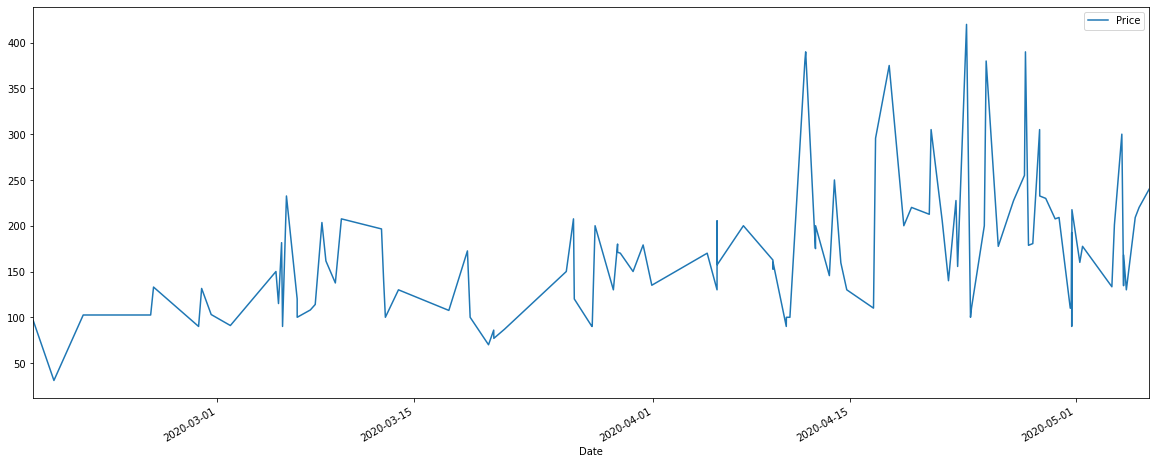

In [155]:
df_parts_only.set_index('Date', inplace=True)
df_parts_only.plot(y='Price', figsize=[20,8]);

In [164]:
df_parts_only.sort_values(by='Date')

,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
Date,,,,,,,,,
2020-02-16 22:46:00,Nintendo Switch 32GB Sold As Is Or For Parts,96.53,9.90,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Sold-As-Is-Or-For-Parts-/264633850405?_trksid=p234...,"['Los Angeles', 'California', 'United States']",mh_disneycollectables,173.0,85.2
2020-02-18 10:06:00,Nintendo Switch Accessories,31.00,4.95,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-Accessories/153831623149?hash=item23d11449ed:g:-PsAAOSw...,"['Indianapolis', 'Indiana', 'United States']",discountgrab,31559.0,99.4
2020-02-20 12:01:00,Nintendo Switch 32GB Sold As Is Or For Parts,102.50,9.90,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Sold-As-Is-Or-For-Parts/264638318827?epid=23024812...,"['Los Angeles', 'California', 'United States']",mh_disneycollectables,173.0,85.2
2020-02-25 07:00:00,Nintendo Switch - 32GB Gray System Console - Tablet Screen Only -NOT WORKING,102.50,23.15,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-System-Console-Tablet-Screen-Only-NOT-WORKING...,"['Middlefield', 'Ohio', 'United States']",ohiovolkswagenadventure,358.0,100.0
2020-02-25 11:55:00,Nintendo Switch HAC-001(-01) 32GB Console with Gray Joy‑Con,133.00,8.30,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-HAC-001-01-32GB-Console-with-Gray-Joy-Con/124088684870?...,"['Waterbury', 'Connecticut', 'United States']",vwtech86,76.0,100.0
2020-02-28 16:28:00,Nintendo Switch 32GB Console - DEFECTIVE POWER,90.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-DEFECTIVE-POWER/283799103782?epid=23024812...,"['Santa Clarita', 'California', 'United States']",yoursavings,6680.0,99.1
2020-02-28 16:42:00,Nintendo Switch 32GB Console - DEFECTIVE POWER,90.00,0.00,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-DEFECTIVE-POWER-/303502155985?_trksid=p234...,"['Santa Clarita', 'California', 'United States']",yoursavings,6680.0,99.1
2020-02-28 21:54:00,"Nintendo Switch 32GB Console Tablet Only (Not Working, For Parts Only)",131.50,14.99,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Console-Tablet-Only-Not-Working-For-Parts-Only-/14...,"['Hackettstown', 'New Jersey', 'United States']",blof94,52.0,100.0
2020-02-29 14:11:00,Nintendo Switch 32GB Gray 4 consoles only for parts or repair not working,103.00,15.05,Parts Only,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-4-consoles-only-for-parts-or-repair-not-worki...,"['Arlington Heights', 'Illinois', 'United States']",krbunches365,3634.0,100.0


In [162]:
df_parts_only.shape

(151, 9)

In [159]:
for title in df.Title:
    if 'sd' in title.lower() and 'gb' in title.lower():
        print(title)

Nintendo Switch HAC-001(-01) With Accesories and 128GB SD
Nintendo Switch (Latest Model) - Gray - Pro Controller & 512GB SD Card
Nintendo Switch 32GB Console w/ Gray Joy Cons, Games, 64GB micro SD card BUNDLE 
Nintendo Switch 32GB Neon Bundle 1 yr online Family Plan 128gb micro sd and case
Nintendo Switch V2 Console with Gray Joyâ€‘Con (BRAND NEW) Incld. 128 GB mSDXC
Nintendo Switch Console (Joy-Cons) - Complete in Box + 128 GB Micro SD Card 
Nintendo Switch, Mario Kart, Smash Broâ€™s, Pro Controller, 256GB SD, Adult Owned
Nintendo Switch V1 with 4 Joyâ€‘Cons, grips, case, 2 games, 128GB microSD + MORE!
Nintendo Switch 32GB Console + 128 GB MicroSD Card, Case, Charger, Headphones
Nintendo Switch Console w/ Gray Joy‑Con 32GB, w/ Games, SD Card & Pro Controller
Nintendo Switch Console (Joy-Cons) + 128 GB Micro SD
Nintendo Switch Console 32GB w/ 64GB Sd w/ case, game, and stand - red & blue 
Nintendo Switch 32GB (128GB MicroSD) Console & Mario Kart 8 Deluxe - Gray
Nintendo Switch Console 

In [66]:
# Fixing location values incorrectly stored as string instead of list
notlist = []
i = 0
for x in df.Location:
    if not isinstance(x, list): notlist.append(i)
    i+=1

for i in notlist:
    df.Location.iloc[i] = [df.Location.iloc[i][1:-1].split(',')[0][1:-1],df.Location.iloc[i][1:-1].split(',')[1][2:-1],
                               df.Location.iloc[i][1:-1].split(',')[2][2:-1]]

df['City'] = df.Location.str[0]
df['State'] = df.Location.str[1]
df['Country'] = df.Location.str[2]

In [71]:
len(notlist)

9097

In [107]:
#df.Location.iloc[242][1:-1].split(',')[2][2:-1]

'United States'

<img src="sales.PNG" width="400">

## Conclusions

Nintendo spearheads a minority of companies that has enjoyed a tremendous surge in sales due to the global coronavirus pandemic. It should be no surprise that they aren't shy about publicizing the success of the switch per the chart above from their [website.](https://www.nintendo.co.jp/ir/en/finance/hard_soft/number.html)
Even still today in mid-May 2020, one can do a cursory search on Google Shopping, Amazon and confirm that either units (sold at retail price) are out of stock or being marked up anywhere from 40-100%.

## Closing Remarks, Reflection, Further Work

When I had originally chosen this capstone project focus, I had thought that one of the pitfalls would be finding creative ways to add complexity. I envisioned pulling every custom added image and text from each seller's listing to use unsupervised/deep learning techniques and models such as NLP and image classifiers to help differentiate reasons for varying closing prices. I was also adamant about scraping the html data manually so I could gain a more comprehensive understanding vs using eBay's API and making the data collection portion much quicker.

What I was not prepared for was how much time I needed to set aside for **data collection** alone; then **data cleaning** which also took several magnitudes longer than I had anticipated (if 70-80% is normal, this project for me was **~90-95%**). I encountered unforeseen frustrations with the inconsistencies of eBay's site, which was prone to 'randomly' change the layout of a completed listing page: Suddenly replacing the body with a similar (live) item ad, randomly losing a closed listing's page (correlated with how old the page was and exponentially more likely after 3 months), different and mutating layouts for power sellers and stores, inconsistencies with where/if information like a seller's feedback would be (sometimes in closed listing page, other times have to navigate to user's profile, some new users don't have a % calculated/displayed). In addition, mistakes when sellers described their items - often filling information incorrectly in pre-defined fields - or sometimes intentionally, attempting to stand out from the crowd.



Be able to differentiate between stores and auctions, get specific bidding data (increments, timestamps, number of final bidders involved). Get data on current (active) stores that set a fixed price with quantities available showing.